In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import math, tensorflow, random as tf
from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import statsmodels.api as sm

SEED = 2025
random.seed(SEED);
np.random.seed(SEED);
tensorflow.random.set_seed(SEED)

Data Collection

In [ ]:
# Collecting Data (FRED)
MATS = {"3M": "DGS3MO", "2Y": "DGS2", "5Y":"DGS5", "10Y":"DGS10"}

# Downloading Treasury yields from FRED
df = pd.concat({k: pdr.DataReader(v, "fred", start ="2015-01-01")for k,v in MATS.items()},axis=1)
df = df.dropna().sort_index()
df.head()

,3M,2Y,5Y,10Y
,DGS3MO,DGS2,DGS5,DGS10
DATE,,,,
2015-01-02,0.02,0.66,1.61,2.12
2015-01-05,0.03,0.68,1.57,2.04
2015-01-06,0.03,0.65,1.50,1.97
2015-01-07,0.03,0.62,1.47,1.96
2015-01-08,0.03,0.62,1.50,2.03


Preprocessing

In [ ]:
from re import split
#Preprocessing

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values) # scale all maturities to [0,1]

cols = df.columns.tolist()
target_idx = cols.index("10Y_DGS10")

#Creating sequences (30 day lookback to predict next-day 10 Year)
LOOKBACK = 30
X, y =[],[]
for i in range(LOOKBACK, len(scaled)):
    X.append(scaled[i-LOOKBACK:i, :])     #last 30 days
    y.append(scaled[i, target_idx])       # next-day 10 years
X, y = np.array(X), np.array(y)

#Train/Test Split (80/20, no shuffle to preserve time order)
split = int (len(X)*0.80)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


LSTM model


In [ ]:

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.20),
    LSTM(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.10, verbose=1)

Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 0.0130 - val_loss: 0.0138
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0010 - val_loss: 0.0100
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 8.5123e-04 - val_loss: 0.0041
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 8.9738e-04 - val_loss: 0.0027
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 7.5059e-04 - val_loss: 0.0031
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 7.0588e-04 - val_loss: 0.0013
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.0130e-04 - val_loss: 0.0020
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 6.7174e-04 - val_loss: 0.0016
Epoch 9/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 6.1926e-04 - val_loss: 0.0016
Epoch 10/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 5.9017e-04 - val_loss: 0.0017
Epoch 11/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 5.3603e-04 - val_loss: 0.0010
Epoch 12/30
60/60 ━━━━━━━━━━━━━━━━━━━━

LTSM Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
LSTM RMSE: 0.0463 | MAPE: 0.0498


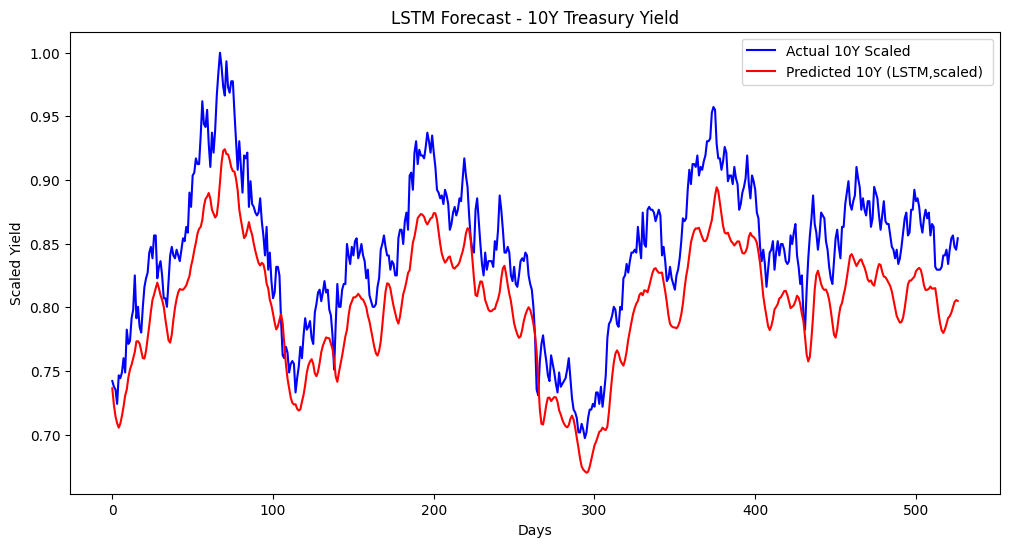

In [ ]:
y_pred_test = model.predict(X_test)

rmse_lstm = math.sqrt(mean_squared_error(y_test, y_pred_test))
mape_lstm = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"LSTM RMSE: {rmse_lstm:.4f} | MAPE: {mape_lstm:.4f}")

#Ploting Actual vs Predicted Scaled

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual 10Y Scaled', color='blue')
plt.plot(y_pred_test, label='Predicted 10Y (LSTM,scaled) ', color='red')
plt.title("LSTM Forecast - 10Y Treasury Yield")
plt.xlabel("Days")
plt.ylabel("Scaled Yield")
plt.legend()
plt.show()

ARIMA Baseline

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

ARIMA RMSE: 0.4241 | MAPE: 0.0841


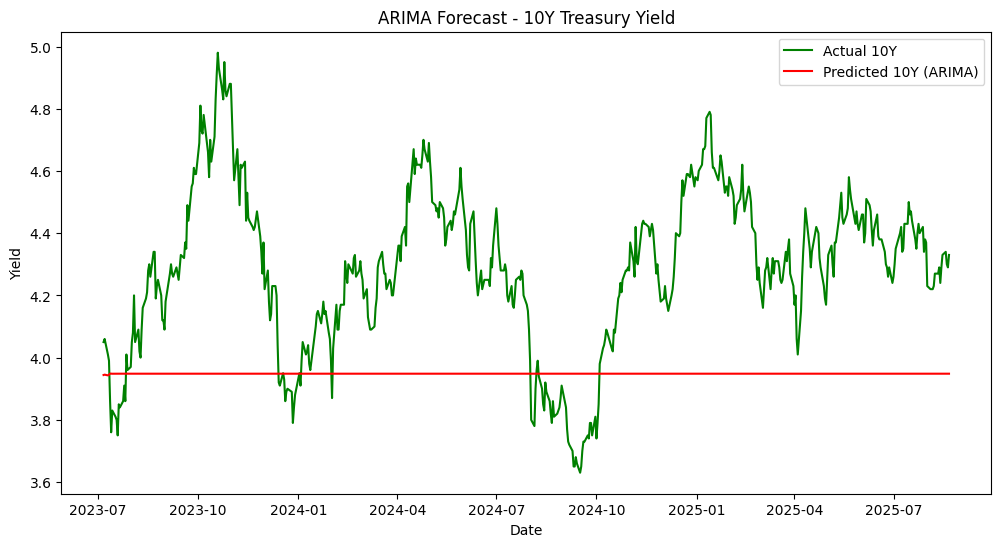

In [ ]:
series_10y = df["10Y_DGS10"].copy()
cut = int(len(series_10y)*0.80)
ar_train, ar_test = series_10y.iloc[:cut], series_10y.iloc[cut:]

arima = sm.tsa.ARIMA(ar_train, order=(5,1,0))
arima_fit = arima.fit()
ar_forecast = arima_fit.forecast(steps=len(ar_test))

rmse_arima = math.sqrt(mean_squared_error(ar_test, ar_forecast.values))
mape_arima = mean_absolute_percentage_error(ar_test, ar_forecast.values)

print(f"ARIMA RMSE: {rmse_arima:.4f} | MAPE: {mape_arima:.4f}")

#Plot ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(ar_test.index, ar_test.values,label='Actual 10Y', color='green')
plt.plot(ar_test.index,ar_forecast.values, label='Predicted 10Y (ARIMA)', color='red')
plt.title("ARIMA Baseline - 10Y Treasury Yield")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend()
plt.show()
